# Greedy Method For Fitting Beryllium's Atomic Density


This file will showcase how to use the greedy method for optimizing the Kullback-Leibler divergence functions
that iteratively selects the next best $(n + 1)$ basis functions from the previous $n$ basis functions.

There are three different choices of picking the next set of basis-functions, the one we're going to use
in this example is the `pick_one`. This generetes the next set of initial guesses by taking the average between
each consequent exponent, and multiplies the smallest and largest exponent by a constant $C$.  For example,
for three exponents $\{\alpha_1, \alpha_2, \alpha_3\}$, the three next initial guesses are

$$\mathcal{C} = \bigg\{ \{C\alpha_1, \alpha_2, \alpha_3 \}, \big\{\alpha_1, \frac{\alpha_1 + \alpha_2}{2}, \alpha_3 \big\}, \big\{ \alpha_1, \alpha_2, \frac{\alpha_2 + \alpha_3}{2}, \alpha_3 \big\}, \big\{\alpha_1, \alpha_2, C \alpha_3\big\} \bigg\}. $$

The greedy algorithm would optimize each initial guess in $\mathcal{C}$ and picks the best "local" answer found and further
optimizes it.  Then, this optimal answer is then used for the next `5` basis-functions.

## 1. Specify a radial grid.

The first step is to specify a one-dimensional (radial) grid.

The ClenshawCurtis grid is chosen here and is recommended for radial grids since it centers the points where the electron density is thought to be high.
However, just to make sure let's add additional points [25, 50, 75]. 

In [1]:
import numpy as np
from bfit.grid import ClenshawRadialGrid

atomic_numb = 4
grid = ClenshawRadialGrid(atomic_numb, num_core_pts=400, num_diffuse_pts=500, 
                          extra_pts=[25, 50, 75])

## 2. Get Slater density.

The next step is to get the atomic density of Beryllium.

Additionally, let's integrate it spherically to make sure the integral of the atomic density is indeed close to the atomic number $4$ and let's plot it.

The integral of potassium is:  3.9999910287814453894


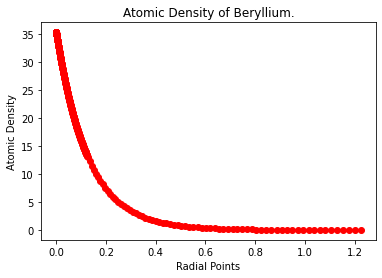

In [2]:
%matplotlib inline
from bfit.density import SlaterAtoms

# Grab information about potassium.
be = SlaterAtoms("be")

# Get the total electronic density.
density = be.atomic_density(grid.points, mode="total")

print("The integral of potassium is: ", grid.integrate(density * 4.0 * np.pi * grid.points**2.0))

# Plot only the first 500 points.
import matplotlib.pyplot as plt
plt.plot(grid.points[:500], density[:500], "ro-")
plt.xlabel("Radial Points")
plt.ylabel("Atomic Density")
plt.title("Atomic Density of Beryllium.")
plt.show()

## 3. Construct Greedy-KL Object.

All the pieces are in place to provide to the "KLDivergenceFPI" class. Here, want to make sure that `spherical=True` since we're dealing with radial atomic densities. The `pick-one` attribute specifies how the next set of basis-functions are chosen and finally the `l_maxiter` and `g_maxiter` specifies the number of iterations needed for the local choice and global choice.  We specify a large number for the global choice so that it optimizes and refines the best found local choice.

In [3]:
from bfit.greedy import GreedyKLFPI

greedy = GreedyKLFPI(grid, density, "pick-one", l_maxiter=2500, g_maxiter=5000, spherical=True)

------------------------------------------------------------------------------------------------------------------------------------------------
|# of Functions | # of S-type | # of P-type |  Integration  |      L1       |   L Infinity   | Least-squares |Kullback-Leibler|Change Objective|
------------------------------------------------------------------------------------------------------------------------------------------------
|       1       |      1      |      0      |   3.999983    | 3.758501e+00  |  3.524177e+01  | 7.943230e+00  |  4.733178e+00  |      nan       |
|       2       |      2      |      0      |   3.999907    | 7.253813e-01  |  2.631367e+01  | 1.031142e+00  |  1.394058e-01  |  4.575385e+00  |
|       3       |      3      |      0      |   3.999924    | 3.799149e-01  |  1.722084e+01  | 1.043090e-01  |  4.636776e-02  |  9.294167e-02  |
|       4       |      4      |      0      |   3.999953    | 1.323686e-01  |  1.620842e+01  | 7.630855e-02  |  4.721414e-03  |  4

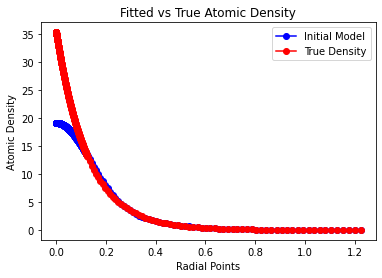

In [4]:
max_numb_functions = 4
factor = 50.0
result = greedy.run(factor, max_numb_funcs=max_numb_functions, disp=True)

from bfit.model import AtomicGaussianDensity
model = AtomicGaussianDensity(grid.points, num_s = result["num_s"], normalize=True)
print(result["coeffs"])
model0 = model.evaluate(result["coeffs"], result["exps"])

numb_pts = 500
plt.plot(grid.points[:numb_pts], model0[:numb_pts], "bo-", label="Initial Model")
plt.plot(grid.points[:numb_pts], density[:numb_pts], "ro-", label="True Density")
plt.xlabel("Radial Points")
plt.ylabel("Atomic Density")
plt.title("Fitted vs True Atomic Density")
plt.legend()
plt.show()

It becomes apparent that more basis-functions are needed in order to capture the cusp better. Free-free to re-run and modify the calculation as needed.